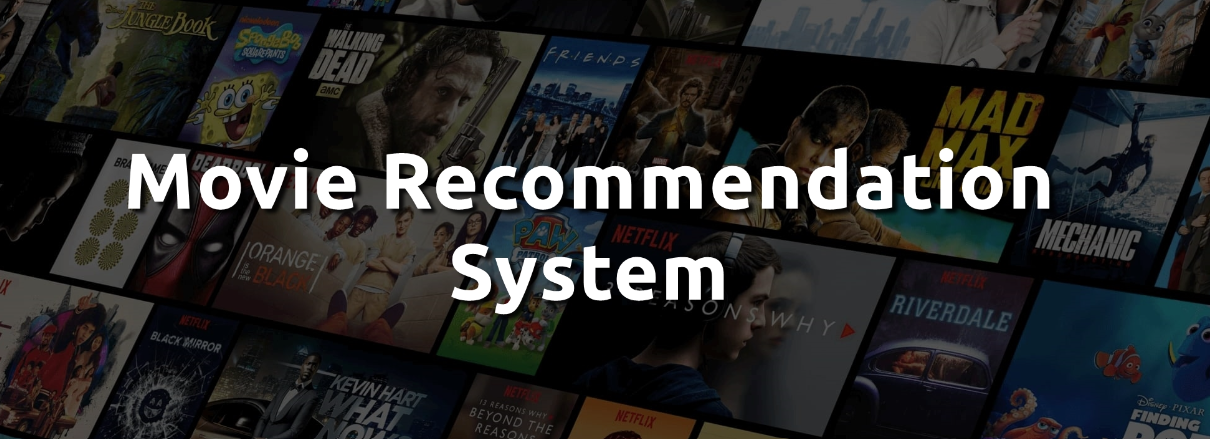

# **Movie Recommendation System**

Recommendation systems are algorithms designed to recommend items to users based on their preferences and behavior. These systems are widely used across various platforms, such as online stores, movie streaming services, and job portals. In this notebook, we will explore two types of recommendation systems: Content-based filtering, which suggests items similar to those a user has shown interest in based on item features, and Collaborative filtering, which recommends items by analyzing the preferences of similar users or identifying patterns in user-item interactions.

Using Python and the Pandas library, we will implement both approaches. For content-based filtering, we will focus on analyzing item attributes (like movie genres) and computing similarities to recommend relevant items. For collaborative filtering, we will leverage user behavior data to recommend items based on patterns shared with other users. This notebook will guide you through building and evaluating these recommendation models, offering insights into their differences and practical applications.

## **Data Preprocessing**

First lets download the dataset from GroupLens.

In [1]:
!wget -O moviedataset.zip https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%205/data/moviedataset.zip
print('unziping ...')
!unzip -o -j moviedataset.zip

--2024-10-06 22:10:22--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%205/data/moviedataset.zip
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.63.118.104
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.63.118.104|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 160301210 (153M) [application/zip]
Saving to: ‘moviedataset.zip’

moviedataset.zip    100%[===================>] 152.88M  36.1MB/s    in 4.4s    

2024-10-06 22:10:27 (34.9 MB/s) - ‘moviedataset.zip’ saved [160301210/160301210]

unziping ...
Archive:  moviedataset.zip
  inflating: links.csv               
  inflating: movies.csv              
  inflating: ratings.csv             
  inflating: README.txt              
  inflating: tags.csv        

Lets import the required libraries.

In [2]:
import pandas as pd
from math import sqrt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Then store the datasets on each dataframe.

In [3]:
movies_df = pd.read_csv('movies.csv')
ratings_df = pd.read_csv('ratings.csv')
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


We'll use Pandas' replace function to remove the year from the title column and save it separately in a new year column.

In [4]:
movies_df['year'] = movies_df.title.str.extract('(\(\d\d\d\d\))',expand=False)
movies_df['year'] = movies_df.year.str.extract('(\d\d\d\d)',expand=False)
movies_df['title'] = movies_df.title.str.replace('(\(\d\d\d\d\))', '')
movies_df['title'] = movies_df['title'].apply(lambda x: x.strip())
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


Next, we'll split the values in the Genres column into a list of individual genres for easier future use. This can be done by applying Python's split function to the appropriate column.

In [5]:
movies_df['genres'] = movies_df.genres.str.split('|')
movies_df.head()

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II (1995),[Comedy],1995


Since storing genres as a list isn't ideal for the content-based recommendation system, we’ll apply One Hot Encoding to convert the list of genres into a vector, where each column represents a possible genre. This encoding is necessary for handling categorical data. Each genre will have its own column, with a value of 1 indicating the movie has that genre, and 0 indicating it doesn't. We'll also save this transformed data in a new variable, as the genres won't be needed for our first recommendation system.

In [6]:
moviesWithGenres_df = movies_df.copy()

for index, row in movies_df.iterrows():
    for genre in row['genres']:
        moviesWithGenres_df.at[index, genre] = 1

moviesWithGenres_df = moviesWithGenres_df.fillna(0)
moviesWithGenres_df.head()

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,Father of the Bride Part II (1995),[Comedy],1995,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next, let's look at the ratings dataframe.

In [7]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,169,2.5,1204927694
1,1,2471,3.0,1204927438
2,1,48516,5.0,1204927435
3,2,2571,3.5,1436165433
4,2,109487,4.0,1436165496


Each row in the ratings dataframe contains a user ID, a movie they rated, the rating they gave, and a timestamp indicating when the review was made. Since the timestamp isn't necessary for our analysis, we'll drop this column to conserve memory.

In [8]:
ratings_df = ratings_df.drop('timestamp', axis=1)
ratings_df.head()

,userId,movieId,rating
0,1,169,2.5
1,1,2471,3.0
2,1,48516,5.0
3,2,2571,3.5
4,2,109487,4.0


## **Content-Based recommendation system**

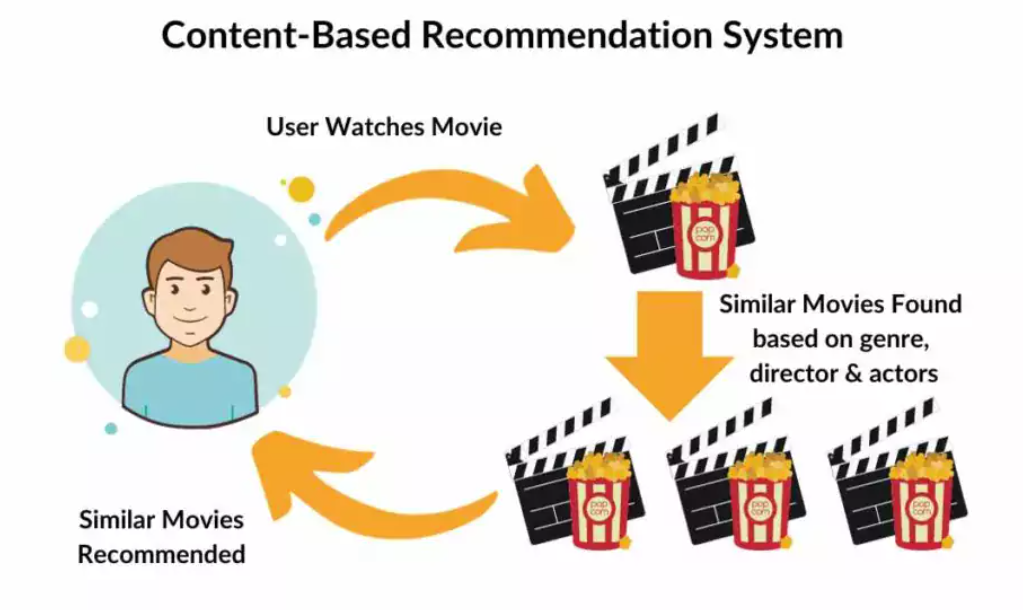

Now, let’s delve into implementing Content-Based or Item-Item recommendation systems. This technique focuses on understanding a user's preferred characteristics of an item and subsequently recommending other items that exhibit those same attributes. The primary goal is to identify the features that the user enjoys most and suggest similar items that align with those preferences.

In our case, we will analyze the movies that the user has rated to determine their favorite genres. By examining the input data, we can extract the genres associated with the movies that received high ratings. This analysis allows us to create a profile of the user's preferences, which we can use to recommend other movies that fall within those favored genres. For instance, if a user has shown a strong preference for action and thriller genres, our system will focus on suggesting new movies that are categorized under those genres. This approach not only personalizes the user experience but also enhances the likelihood of user satisfaction with the recommended items.

**Advantages and Disadvantages of Content-Based Filtering**

Advantages
* Understands and adapts to the user's preferences.
* Provides highly personalized recommendations tailored to the user.

Disadvantages

* Does not consider the opinions of other users, which can lead to recommendations of low-quality items.
* Data extraction may not always be straightforward.
* Identifying which characteristics of an item the user likes or dislikes can be challenging.

Let's start by creating a user input for movie recommendations:

**Note:** To recommend more movies, simply increase the number of elements in the userInput. You can add more titles as desired! Just remember to capitalize the titles, and if a movie begins with "The," such as "The Matrix," format it like this: 'Matrix, The'.

In [9]:
userInput = [
            {'title':'Breakfast Club, The', 'rating':5},
            {'title':'Toy Story', 'rating':3.5},
            {'title':'Jumanji', 'rating':2},
            {'title':"Pulp Fiction", 'rating':5},
            {'title':'Akira', 'rating':4.5}
         ]
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,"Breakfast Club, The",5.0
1,Toy Story,3.5
2,Jumanji,2.0
3,Pulp Fiction,5.0
4,Akira,4.5


**Add movieId to User Input**

Now that we have our input complete, let's extract the movie IDs from the movies dataframe and incorporate them into our input.

To do this, we’ll first filter the rows that match the titles in the user input, and then merge this subset with the input dataframe. Additionally, we will remove any unnecessary columns from the input to conserve memory.

In [10]:
inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())]
inputMovies = pd.merge(inputId, inputMovies)
inputMovies = inputMovies.drop(['genres', 'year'], axis=1)
inputMovies

,movieId,title,rating


To understand the user's preferences, we'll begin by retrieving the subset of movies they have watched from the dataframe, which contains genres represented as binary values.

In [11]:
userMovies = moviesWithGenres_df[moviesWithGenres_df['movieId'].isin(inputMovies['movieId'].tolist())]
userMovies

,movieId,title,genres,year,Adventure,Animation,Children,Comedy,Fantasy,Romance,...,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)


Since we only require the actual genre table, let's tidy it up by resetting the index and removing the movieId, title, genres, and year columns.

In [12]:
userMovies = userMovies.reset_index(drop=True)
userGenreTable = userMovies.drop(['movieId', 'title', 'genres', 'year'], axis=1)
userGenreTable

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)


To achieve this, we will convert each genre into weighted values. This involves taking the user's reviews and multiplying them by the corresponding entries in the genre table, followed by summing the results for each column. This process essentially performs a dot product between a matrix and a vector, which we can easily execute using the Pandas dot function.

In [13]:
inputMovies['rating']

,rating


In [14]:
userProfile = userGenreTable.transpose().dot(inputMovies['rating'])
userProfile

,0
Adventure,0.0
Animation,0.0
Children,0.0
Comedy,0.0
Fantasy,0.0
Romance,0.0
Drama,0.0
Action,0.0
Crime,0.0
Thriller,0.0


We now have the weights representing each of the user's preferences, which is referred to as the User Profile. With this profile, we can recommend movies that align with the user's preferences. Let's start by extracting the genre table from the original dataframe:

In [15]:
genreTable = moviesWithGenres_df.set_index(moviesWithGenres_df['movieId'])
genreTable = genreTable.drop(['movieId', 'title', 'genres', 'year'], axis=1)
genreTable.head()

,Adventure,Animation,Children,Comedy,Fantasy,Romance,Drama,Action,Crime,Thriller,Horror,Mystery,Sci-Fi,IMAX,Documentary,War,Musical,Western,Film-Noir,(no genres listed)
movieId,,,,,,,,,,,,,,,,,,,,
1,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
genreTable.shape

(34208, 20)

With the user's profile and the complete list of movies and their genres available, we will calculate the weighted average for each movie based on the user profile and recommend the top twenty movies that best match their preferences. Now here's the recommendation table!

In [17]:
recommendationTable_df = ((genreTable*userProfile).sum(axis=1))/(userProfile.sum())
recommendationTable_df = recommendationTable_df.sort_values(ascending=False)
movies_df.loc[movies_df['movieId'].isin(recommendationTable_df.head(20).keys())]

,movieId,title,genres,year
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",1995
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",1995
2,3,Grumpier Old Men (1995),"[Comedy, Romance]",1995
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]",1995
4,5,Father of the Bride Part II (1995),[Comedy],1995
5,6,Heat (1995),"[Action, Crime, Thriller]",1995
6,7,Sabrina (1995),"[Comedy, Romance]",1995
7,8,Tom and Huck (1995),"[Adventure, Children]",1995
8,9,Sudden Death (1995),[Action],1995
9,10,GoldenEye (1995),"[Action, Adventure, Thriller]",1995


## **Collaborative-based recommendation system**

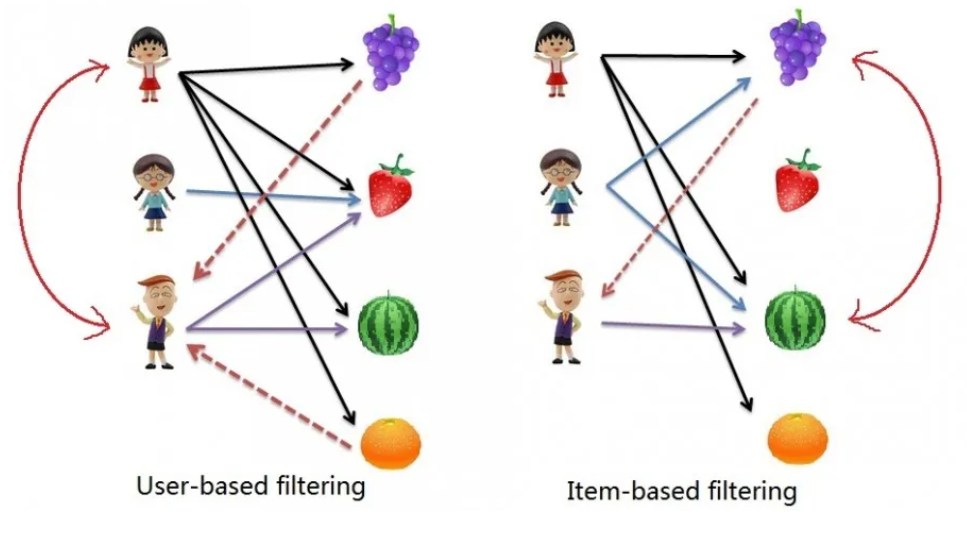

Now it's time to dive into our exploration of recommendation systems.

The first technique we will examine is Collaborative Filtering, also known as User-User Filtering. As its alternative name suggests, this method relies on other users to recommend items to the input user. The core idea is to identify users with similar preferences and opinions to the input user, then suggest items that these like-minded users have enjoyed. There are various techniques for identifying similar users, some of which leverage machine learning; however, we will focus on a method based on the Pearson Correlation Coefficient.

The steps for creating a User-Based recommendation system are as follows:

Select a user based on the movies they have watched.
Identify the top X similar users based on their ratings of those movies.
Retrieve the watched movie records from each of these similar users.
Calculate a similarity score using an appropriate formula.
Recommend items with the highest similarity scores.

**Advantages and Disadvantages of Collaborative Filtering**

Advantages
* Considers other users' ratings in the recommendation process.
* Does not require analysis or extraction of information from the recommended item itself.
* Adapts to the user’s changing interests over time.

Disadvantages
* The approximation function can be slow, especially with large datasets.
* There may be a limited number of users available for accurate approximations.
* Privacy concerns may arise when attempting to understand a user's preferences.

Let’s begin by creating an input user for whom we will recommend movies:

Note: To add more movies, simply increase the number of elements in the userInput. You can add as many titles as you like! Just remember to capitalize the titles, and if a movie starts with "The," like "The Matrix," format it as 'Matrix, The'.

In [43]:
userInput = [
    {'title': 'The Breakfast Club (1985)', 'rating': 5},
    {'title': 'Toy Story (1995)', 'rating': 3.5},
    {'title': 'Jumanji (1995)', 'rating': 2},
    {'title': "Pulp Fiction (1994)", 'rating': 5},
    {'title': 'Akira (1988)', 'rating': 4.5}
]
inputMovies = pd.DataFrame(userInput)
inputMovies

,title,rating
0,The Breakfast Club (1985),5.0
1,Toy Story (1995),3.5
2,Jumanji (1995),2.0
3,Pulp Fiction (1994),5.0
4,Akira (1988),4.5


With the input user information finalized, we can proceed to extract the movie IDs corresponding to the titles provided from the movies DataFrame. This step is crucial for associating the user’s preferences with the correct identifiers in our recommendation system.

To accomplish this, we'll first filter the movies DataFrame to locate the rows that match the titles in our input list. After identifying these relevant rows, we'll merge this subset with the input DataFrame to enrich our user input with the corresponding movieId. Additionally, to optimize memory usage and streamline our dataset, we will drop any unnecessary columns that are not needed for the recommendation process. This ensures that our DataFrame remains focused on the essential information required for generating accurate recommendations.

In [44]:
inputId = movies_df[movies_df['title'].isin(inputMovies['title'].tolist())]
inputMovies = pd.merge(inputId, inputMovies, on='title')
inputMovies = inputMovies.drop('year', axis=1)
inputMovies

,movieId,title,genres,rating
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",3.5
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]",2.0
2,296,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]",5.0
3,1274,Akira (1988),"[Action, Adventure, Animation, Sci-Fi]",4.5


Now that we have the movie IDs in our input, we can extract the subset of users who have watched and reviewed the same movies. This will allow us to identify like-minded users whose preferences align with those of the input user, providing a foundation for generating personalized recommendations.

In [45]:
userSubset = ratings_df[ratings_df['movieId'].isin(inputMovies['movieId'].tolist())]
userSubset.head()

,userId,movieId,rating
19,4,296,4.0
479,13,2,2.0
531,13,1274,5.0
681,14,296,2.0
749,15,1,4.0


We will now group the rows by user ID.

In [46]:
userSubsetGroup = userSubset.groupby(['userId'])
userSubsetGroup

Let's examine one of the users, specifically the one with user ID 1130.

In [47]:
userSubsetGroup.get_group(1130)

<ipython-input-47-6d1ec53f9ef3>:1: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  userSubsetGroup.get_group(1130)


,userId,movieId,rating
104167,1130,1,0.5
104168,1130,2,4.0
104214,1130,296,4.0
104363,1130,1274,4.5


Let's sort these groups so that users with the most movies in common with the input are prioritized. This approach enhances our recommendations by allowing us to focus on users who are most likely to provide relevant suggestions, rather than sifting through every single user.

In [48]:
userSubsetGroup = sorted(userSubsetGroup,  key=lambda x: len(x[1]), reverse=True)

Now let's look at the first user.

In [49]:
userSubsetGroup[0:3]

[((75,),
        userId  movieId  rating
  7507      75        1     5.0
  7508      75        2     3.5
  7540      75      296     5.0
  7633      75     1274     4.5),
 ((106,),
        userId  movieId  rating
  9083     106        1     2.5
  9084     106        2     3.0
  9115     106      296     3.5
  9198     106     1274     3.0),
 ((217,),
         userId  movieId  rating
  19726     217        1     4.0
  19727     217        2     2.0
  19751     217      296     5.0
  19812     217     1274     3.5)]

**Similarity of Users to Input User**
Next, we will compare various users (though not all users) to our specified input user to identify the one who is most similar. To accomplish this, we'll evaluate how similar each user is to the input user using the Pearson Correlation Coefficient. This coefficient measures the strength and direction of a linear relationship between two variables, and it is particularly useful in understanding user preferences in recommendation systems.

The formula for calculating the Pearson correlation coefficient between two sets of data,
𝑋
X and
𝑌
Y, with
𝑁
N values can be illustrated in the image below:

![alt text](https://wikimedia.org/api/rest_v1/media/math/render/svg/bd1ccc2979b0fd1c1aec96e386f686ae874f9ec0 "Pearson Correlation")

Why Use Pearson Correlation?
The choice of the Pearson correlation coefficient is significant because it is invariant to scaling. This means that multiplying all elements in a dataset by a nonzero constant or adding a constant to all elements does not affect the outcome of the correlation. For example, if you have two vectors
𝑋
X and
𝑌
Y, the relationship holds:

pearson
(
𝑋
,
𝑌
)
=
pearson
(
𝑋
,
2
⋅
𝑌
+
3
)
pearson(X,Y)=pearson(X,2⋅Y+3)
This property is crucial in recommendation systems. For instance, two users might rate the same series of items quite differently in absolute terms, but they can still share similar tastes or preferences when normalized. Therefore, even if their ratings are on different scales, a high Pearson correlation indicates that they have similar perspectives on the items.

Interpreting the Pearson Correlation Coefficient
The values produced by the Pearson correlation coefficient range from
𝑟
=
−
1
r=−1 to
𝑟
=
1
r=1:

𝑟
=
1
r=1: This indicates a perfect positive correlation between the two entities, meaning they have identical preferences.
𝑟
=
−
1
r=−1: This signifies a perfect negative correlation, indicating opposing tastes.
In our context, a value of
1
1 means that the two users have very similar tastes in movies, while a value of
−
1
−1 indicates the opposite, suggesting that the users have completely divergent preferences. By employing this method, we can efficiently pinpoint users whose ratings align closely with the input user's preferences, allowing for more personalized and relevant movie recommendations.

We will choose a specific subset of users to analyze. This limitation is necessary to avoid spending excessive time examining every single user in the dataset.

In [50]:
userSubsetGroup = userSubsetGroup[0:100]

Next, we will compute the Pearson Correlation between the input user and the subset group, storing the results in a dictionary where the user ID serves as the key and the corresponding coefficient as the value.

In [52]:
pearsonCorrelationDict = {}
for name, group in userSubsetGroup:
    group = group.sort_values(by='movieId')
    inputMovies = inputMovies.sort_values(by='movieId')
    nRatings = len(group)
    temp_df = inputMovies[inputMovies['movieId'].isin(group['movieId'].tolist())]
    tempRatingList = temp_df['rating'].tolist()
    tempGroupList = group['rating'].tolist()
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(nRatings)

    if Sxx != 0 and Syy != 0:
        pearsonCorrelationDict[name] = Sxy/sqrt(Sxx*Syy)
    else:
        pearsonCorrelationDict[name] = 0


pearsonCorrelationDict.items()
pearsonDF = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['userId'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

,similarityIndex,userId
0,0.801784,"(75,)"
1,0.462910,"(106,)"
2,0.881917,"(217,)"
3,0.592157,"(393,)"
4,0.881917,"(686,)"


Let's now identify the top 50 users who are most similar to the input user.

In [53]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:50]
topUsers.head()

,similarityIndex,userId
92,0.991460,"(9721,)"
59,0.991460,"(6157,)"
60,0.986928,"(6207,)"
57,0.986928,"(6082,)"
22,0.986928,"(2839,)"


Now, let’s begin recommending movies to the input user.

**Ratings from Selected Users for All Movies**

We will accomplish this by calculating the weighted average of the movie ratings, using the Pearson Correlation as the weight. To do this, we first need to extract the movies watched by the users in our pearsonDF from the ratings dataframe. We will then add their correlation as a new column titled similarityIndex. This process is achieved through the merging of these two tables, as shown below.

In [57]:
# Check the structure of the userId column in topUsers
print(topUsers['userId'].unique())
print(topUsers['userId'].apply(type).unique())

# Extract the first element from tuples in userId, if necessary, and convert to int
topUsers['userId'] = topUsers['userId'].apply(lambda x: x[0] if isinstance(x, tuple) else x).astype(int)

# Convert userId in ratings_df to int (if it’s not already)
ratings_df['userId'] = ratings_df['userId'].astype(int)

# Perform the merge
topUsersRating = topUsers.merge(ratings_df, on='userId', how='inner')
print(topUsersRating.head())

[(9721,) (6157,) (6207,) (6082,) (2839,) (4072,) (5104,) (9358,) (7027,)
 (5687,) (10210,) (7388,) (1066,) (4644,) (5919,) (1040,) (6791,) (3051,)
 (5547,) (7968,) (7220,) (1414,) (4292,) (5857,) (4079,) (9250,) (10236,)
 (5833,) (217,) (686,) (9994,) (7641,) (2791,) (1966,) (8675,) (3040,)
 (7403,) (10143,) (1502,) (1625,) (8572,) (6687,) (1824,) (75,) (9036,)
 (5131,) (7235,) (4818,) (6506,) (8086,)]
[<class 'tuple'>]
   similarityIndex  userId  movieId  rating
0          0.99146    9721        1     3.5
1          0.99146    9721        2     2.0
2          0.99146    9721        6     3.0
3          0.99146    9721        7     1.0
4          0.99146    9721       10     1.0


Now, we just need to multiply each movie's rating by its corresponding weight (the similarity index), sum the resulting ratings, and then divide by the total of the weights.

We can achieve this by multiplying two columns together, grouping the DataFrame by movieId, and performing the division of the summed ratings by the total weights:

This approach illustrates how all users with similar tastes have rated the candidate movies for the input user:

In [59]:
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['rating']
tempTopUsersRating = topUsersRating.groupby('movieId').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
recommendation_df = pd.DataFrame()
recommendation_df['weighted average recommendation score'] = tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex']
recommendation_df['movieId'] = tempTopUsersRating.index
recommendation_df.head()

,weighted average recommendation score,movieId
movieId,,
1,3.688037,1
2,2.505596,2
3,2.895830,3
4,2.000000,4
5,2.448560,5


Now, let's sort the results to reveal the top 20 movies recommended by the algorithm!

In [61]:
recommendation_df = recommendation_df.sort_values(by='weighted average recommendation score', ascending=False)
movies_df.loc[movies_df['movieId'].isin(recommendation_df.head(20)['movieId'].tolist())]

,movieId,title,genres,year
660,668,Song of the Little Road (Pather Panchali) (1955),[Drama],1955
3328,3415,"Mirror, The (Zerkalo) (1975)",[Drama],1975
5674,5772,My Dinner with André (1981),[Drama],1981
5834,5932,Burden of Dreams (1982),[Documentary],1982
5904,6002,Love Liza (2002),[Drama],2002
6099,6197,Spider (2002),"[Drama, Mystery]",2002
6181,6279,"Good Thief, The (2002)","[Crime, Drama]",2002
6207,6305,Fahrenheit 451 (1966),"[Drama, Sci-Fi]",1966
8547,26003,Night and Fog (Nuit et brouillard) (1955),"[Crime, Documentary, War]",1955
8579,26052,Pickpocket (1959),"[Crime, Drama]",1959
